In [4]:
# Install kagglehub (usually pre-installed, but safe to include)
!pip install -q kagglehub

import kagglehub
import pandas as pd
import numpy as np
import os
from pathlib import Path

# Download FER2013 dataset
print("📥 Downloading FER2013 dataset...")
path = kagglehub.dataset_download("msambare/fer2013")
print("✅ Dataset downloaded to:", path)

# List files to see structure
print("\n📁 Dataset contents:")
for f in Path(path).rglob('*'):
    if f.is_file():
        print(f"  {f.name} ({f.stat().st_size/1024/1024:.1f} MB)")

📥 Downloading FER2013 dataset...


100%|██████████| 60.3M/60.3M [00:00<00:00, 188MB/s]

Extracting files...


Streaming output truncated to the last 5000 lines.
  PublicTest_34864860.jpg (0.0 MB)
  PrivateTest_20276409.jpg (0.0 MB)
  PrivateTest_1834385.jpg (0.0 MB)
  PrivateTest_20968344.jpg (0.0 MB)
  PrivateTest_88005682.jpg (0.0 MB)
  PrivateTest_38279098.jpg (0.0 MB)
  PrivateTest_13501133.jpg (0.0 MB)
  PrivateTest_48407794.jpg (0.0 MB)
  PublicTest_61313241.jpg (0.0 MB)
  PrivateTest_37003270.jpg (0.0 MB)
  PrivateTest_21494522.jpg (0.0 MB)
  PrivateTest_74313024.jpg (0.0 MB)
  PrivateTest_77008444.jpg (0.0 MB)
  PrivateTest_89545818.jpg (0.0 MB)
  PublicTest_47890160.jpg (0.0 MB)
  PrivateTest_25503161.jpg (0.0 MB)
  PublicTest_24773421.jpg (0.0 MB)
  PublicTest_68726009.jpg (0.0 MB)
  PrivateTest_88502368.jpg (0.0 MB)
  PublicTest_53331541.jpg (0.0 MB)
  PrivateTest_59102222.jpg (0.0 MB)
  PrivateTest_48847091.jpg (0.0 MB)
  PrivateTest_26814656.jpg (0.0 MB)
  PublicTest_86168446.jpg (0.0 MB)
  PublicTest_79793968.jpg (0.0 MB)
  PublicTest_60838687.jpg (0.0 MB)
  PrivateTest_66384891.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import cv2
import os

# Map emotions to stress (Binary Classification)
# FER2013: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
emotion_map_numeric = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy',
                       4: 'sad', 5: 'surprise', 6: 'neutral'}

# Stress = 1 (Negative emotions), No Stress = 0 (Positive/Neutral)
# Using the numeric emotion mapping for consistency to derive stress_label
stress_map_numeric = {0: 1, 1: 1, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0}

def load_image_data(base_path, emotion_map, stress_map):
    image_paths = []
    emotions = []
    stress_labels = []

    # The dataset typically has 'train', 'test', 'validation' subdirectories
    # The previous output also suggested 'PublicTest' and 'PrivateTest' but the directory structure from `rglob` suggests `train`, `validation`, `test` splits within the dataset.
    splits = ['train', 'validation', 'test']

    for split in splits:
        split_path = Path(base_path) / split
        if not split_path.exists():
            continue # Skip if split directory doesn't exist

        print(f"Processing {split} split...")
        for emotion_dir in split_path.iterdir():
            if emotion_dir.is_dir():
                emotion_name = emotion_dir.name.lower()

                # Find the numeric emotion label from the emotion_map
                numeric_emotion = next((k for k, v in emotion_map.items() if v == emotion_name), None)

                if numeric_emotion is not None:
                    stress_value = stress_map[numeric_emotion]
                    for img_file in emotion_dir.glob('*.jpg'):
                        image_paths.append(str(img_file))
                        emotions.append(emotion_name)
                        stress_labels.append(stress_value)
                else:
                    print(f"Warning: Unrecognized emotion directory: {emotion_name} in {split}")

    return pd.DataFrame({
        'filepath': image_paths,
        'emotion_name': emotions,
        'stress_label': stress_labels
    })

print("Loading data from image directories...")
data = load_image_data(path, emotion_map_numeric, stress_map_numeric)

print(f"✅ Loaded {len(data)} samples")
print(f"Columns: {data.columns.tolist()}")
print(f"\nFirst few rows:\n{data.head()}")

# Show distribution
print("\n📊 Emotion Distribution:")
print(data['emotion_name'].value_counts())
print("\n🔴 Stress vs 🟢 No-Stress:")
print(data['stress_label'].value_counts())

Loading data from image directories...
Processing train split...
Processing test split...
✅ Loaded 35887 samples
Columns: ['filepath', 'emotion_name', 'stress_label']

First few rows:
                                            filepath emotion_name  \
0  /root/.cache/kagglehub/datasets/msambare/fer20...        angry   
1  /root/.cache/kagglehub/datasets/msambare/fer20...        angry   
2  /root/.cache/kagglehub/datasets/msambare/fer20...        angry   
3  /root/.cache/kagglehub/datasets/msambare/fer20...        angry   
4  /root/.cache/kagglehub/datasets/msambare/fer20...        angry   

   stress_label  
0             1  
1             1  
2             1  
3             1  
4             1  

📊 Emotion Distribution:
emotion_name
happy       8989
neutral     6198
sad         6077
fear        5121
angry       4953
surprise    4002
disgust      547
Name: count, dtype: int64

🔴 Stress vs 🟢 No-Stress:
stress_label
0    19189
1    16698
Name: count, dtype: int64


In [6]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_and_preprocess_images(df, img_size=(48, 48)):
    """Load images from filepaths and preprocess"""
    X = []
    y = []

    print(f"🔄 Loading {len(df)} images...")

    for idx, row in df.iterrows():
        # Read image
        img = cv2.imread(row['filepath'], cv2.IMREAD_GRAYSCALE)

        if img is None:
            continue  # Skip corrupted files

        # Resize to 48x48 (FER2013 standard)
        img = cv2.resize(img, img_size)

        # Normalize to 0-1
        img = img.astype('float32') / 255.0

        X.append(img)
        y.append(row['stress_label'])

        # Progress update every 5000 images
        if (idx + 1) % 5000 == 0:
            print(f"  Loaded {idx + 1}/{len(df)} images...")

    X = np.array(X).reshape(-1, 48, 48, 1)  # Add channel dimension
    y = np.array(y)

    return X, y

# Load all images
X, y = load_and_preprocess_images(data)

print(f"\n✅ Final dataset:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"🔴 Stress: {np.sum(y)} ({np.mean(y)*100:.1f}%)")
print(f"🟢 No Stress: {len(y) - np.sum(y)} ({(1-np.mean(y))*100:.1f}%)")

🔄 Loading 35887 images...
  Loaded 5000/35887 images...
  Loaded 10000/35887 images...
  Loaded 15000/35887 images...
  Loaded 20000/35887 images...
  Loaded 25000/35887 images...
  Loaded 30000/35887 images...
  Loaded 35000/35887 images...

✅ Final dataset:
X shape: (35887, 48, 48, 1)
y shape: (35887,)
🔴 Stress: 16698 (46.5%)
🟢 No Stress: 19189 (53.5%)


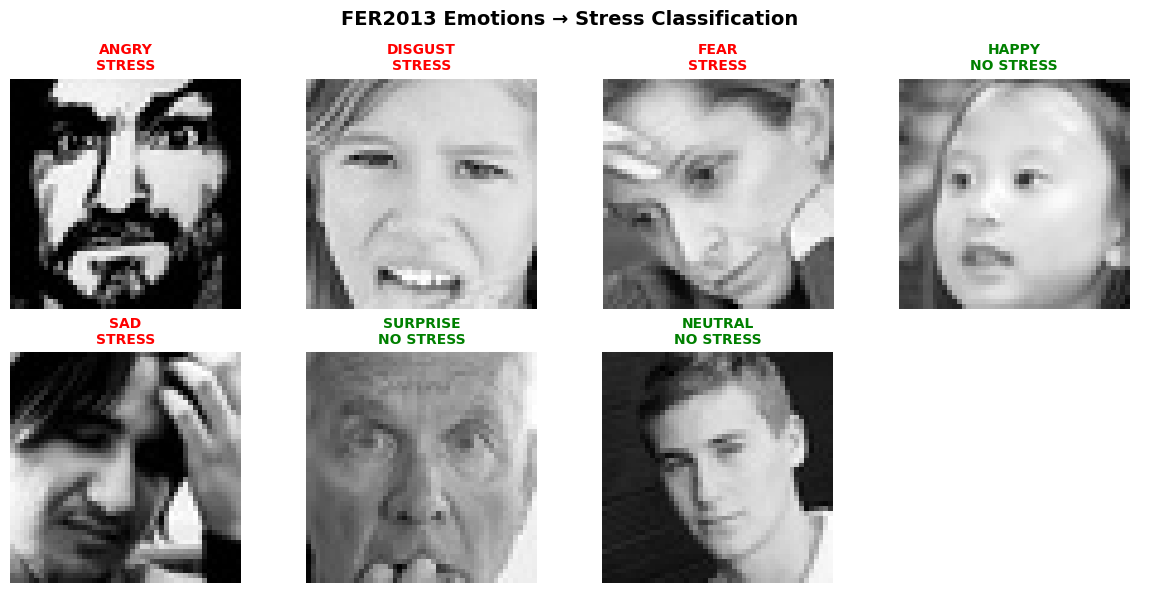

In [7]:
import matplotlib.pyplot as plt
import cv2

# Show sample images from each emotion
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

emotions_to_show = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

for idx, emotion in enumerate(emotions_to_show):
    # Get first image of this emotion
    sample = data[data['emotion_name'] == emotion].iloc[0]
    img = cv2.imread(sample['filepath'], cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (48, 48))

    stress = sample['stress_label']
    color = 'red' if stress == 1 else 'green'
    label = f"{emotion.upper()}\n{'STRESS' if stress else 'NO STRESS'}"

    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(label, color=color, fontweight='bold', fontsize=10)
    axes[idx].axis('off')

axes[7].axis('off')  # Hide empty subplot
plt.suptitle("FER2013 Emotions → Stress Classification", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 Training set: {X_train.shape[0]} samples")
print(f"📊 Test set: {X_test.shape[0]} samples")
print(f"\nTraining balance:")
print(f"  🔴 Stress: {np.mean(y_train)*100:.1f}%")
print(f"  🟢 No Stress: {(1-np.mean(y_train))*100:.1f}%")
print(f"\nTest balance:")
print(f"  🔴 Stress: {np.mean(y_test)*100:.1f}%")
print(f"  🟢 No Stress: {(1-np.mean(y_test))*100:.1f}%")

📊 Training set: 28709 samples
📊 Test set: 7178 samples

Training balance:
  🔴 Stress: 46.5%
  🟢 No Stress: 53.5%

Test balance:
  🔴 Stress: 46.5%
  🟢 No Stress: 53.5%


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Check GPU availability
print("💻 TensorFlow version:", tf.__version__)
print("🔥 GPU Available:", tf.config.list_physical_devices('GPU'))
if tf.config.list_physical_devices('GPU'):
    print("✅ Using GPU for training!")
else:
    print("⚠️ No GPU found, training will be slower")

def build_stress_detector():
    """CNN optimized for 48x48 grayscale facial stress detection"""
    model = models.Sequential([
        # Block 1
        layers.Conv2D(64, (3,3), activation='relu', input_shape=(48, 48, 1)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(256, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # Classifier
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary: Stress/No-Stress
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )

    return model

# Build model
model = build_stress_detector()
model.summary()

💻 TensorFlow version: 2.19.0
🔥 GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Using GPU for training!


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 44, 44, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,869,761 (7.13 MB)

 Trainable params: 1,867,841 (7.13 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights for imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("⚖️ Class weights:", class_weight_dict)

# Use LOWER learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # 10x smaller
    loss='binary_crossentropy',
    metrics=['accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')]
)

print("✅ Recompiled with lower learning rate")

⚖️ Class weights: {0: np.float64(0.9350856621718455), 1: np.float64(1.0745994909417578)}
✅ Recompiled with lower learning rate


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation (less aggressive than before)
train_datagen = ImageDataGenerator(
    rotation_range=10,        # Reduced from 20
    width_shift_range=0.1,    # Reduced from 0.2
    height_shift_range=0.1,   # Reduced from 0.2
    horizontal_flip=True,
    zoom_range=0.1,           # Reduced from 0.2
    brightness_range=[0.9, 1.1]  # Tighter range
)

# No augmentation for validation
val_datagen = ImageDataGenerator()

print("✅ Data generators ready")

✅ Data generators ready


In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, initializers

# CLEAR OLD MODEL
tf.keras.backend.clear_session()

def build_working_stress_model():
    """SIMPLER architecture with better initialization"""
    model = models.Sequential([
        # Input layer (fixes warning)
        layers.Input(shape=(48, 48, 1)),

        # Block 1 - Smaller filters
        layers.Conv2D(32, (3,3), activation='relu',
                     kernel_initializer='he_uniform'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        # Block 2
        layers.Conv2D(64, (3,3), activation='relu',
                     kernel_initializer='he_uniform'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        # Block 3
        layers.Conv2D(128, (3,3), activation='relu',
                     kernel_initializer='he_uniform'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        # Classifier - SIMPLER
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    # HIGHER learning rate initially
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )

    return model

# Build new model
model = build_working_stress_model()
model.summary()
print(f"\nTotal params: {model.count_params():,}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,481 (1.36 MB)

 Trainable params: 355,777 (1.36 MB)

 Non-trainable params: 704 (2.75 KB)


Total params: 356,481


In [16]:
# NO AUGMENTATION - train on raw data first
train_datagen = ImageDataGenerator()  # Just rescaling, no augmentation
val_datagen = ImageDataGenerator()

# STRONGER class weights
class_weight_dict = {0: 1.0, 1: 1.3}  # Heavier weight on stress class

print("⚖️ Class weights:", class_weight_dict)

⚖️ Class weights: {0: 1.0, 1: 1.3}


In [17]:
BATCH_SIZE = 64  # Larger batch
EPOCHS = 30

callbacks_list = [
    callbacks.EarlyStopping(monitor='val_auc', patience=7, restore_best_weights=True, mode='max'),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
]

print("🚀 TRAINING NEW MODEL...")
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=val_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=callbacks_list
)

🚀 TRAINING NEW MODEL...
Epoch 1/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 26s 35ms/step - accuracy: 0.5398 - auc: 0.5569 - loss: 0.9767 - precision: 0.5068 - recall: 0.5748 - val_accuracy: 0.5855 - val_auc: 0.6438 - val_loss: 0.6688 - val_precision: 0.5397 - val_recall: 0.7431 - learning_rate: 0.0010
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6031 - auc: 0.6539 - loss: 0.7529 - precision: 0.5615 - recall: 0.6656 - val_accuracy: 0.6686 - val_auc: 0.7402 - val_loss: 0.5945 - val_precision: 0.6328 - val_recall: 0.6853 - learning_rate: 0.0010
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6574 - auc: 0.7236 - loss: 0.6934 - precision: 0.6114 - recall: 0.7398 - val_accuracy: 0.6828 - val_auc: 0.7618 - val_loss: 0.5770 - val_precision: 0.6339 - val_recall: 0.7533 - learning_rate: 0.0010
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6884 - auc: 0.7625 - loss: 0.6551 - precision: 0.6364 - recall: 0.7685 - val_accuracy: 0.7204 - val_auc: 0.

FINAL MODEL EVALUATION

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   No Stress     0.8262    0.7715    0.7979      3838
      Stress     0.7560    0.8135    0.7837      3340

    accuracy                         0.7910      7178
   macro avg     0.7911    0.7925    0.7908      7178
weighted avg     0.7935    0.7910    0.7913      7178



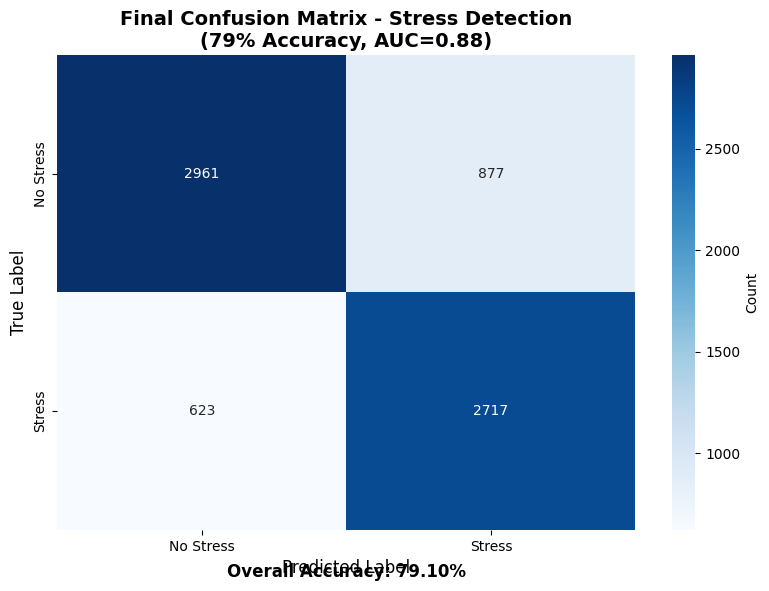

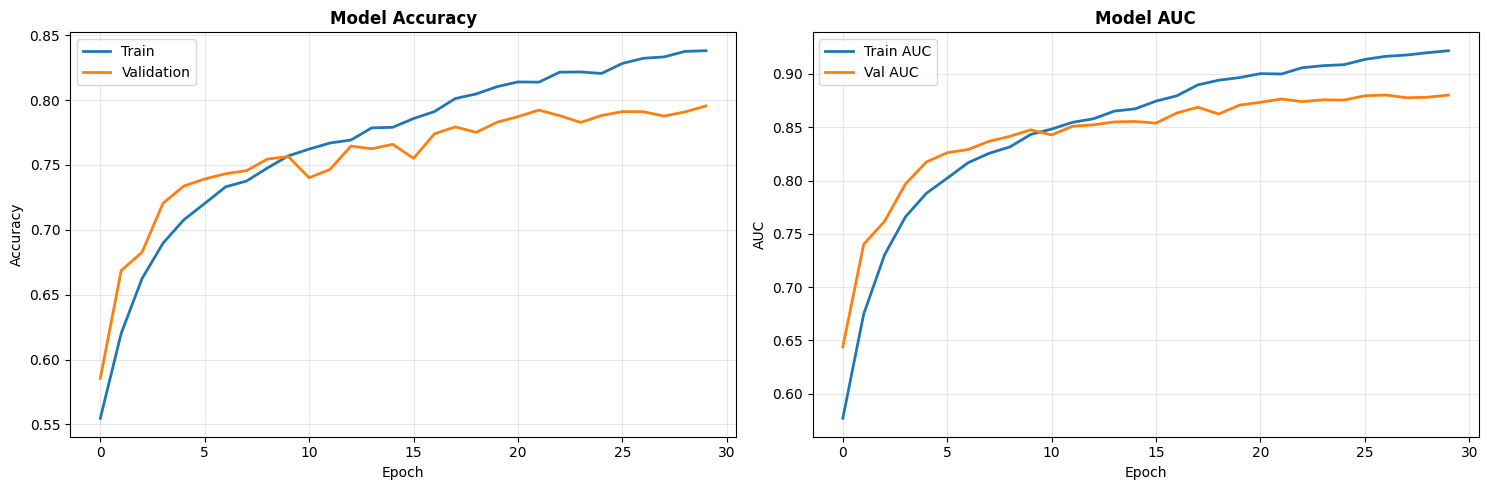


💾 Saving model...
✅ Saved: stress_detection_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎉 PROJECT COMPLETE!
✅ Final Validation Accuracy: 79.55%
✅ Final Validation AUC: 0.8802
✅ Model saved and downloaded


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# 1. FINAL EVALUATION
print("=" * 60)
print("FINAL MODEL EVALUATION")
print("=" * 60)

y_pred_prob = model.predict(X_test, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\n📊 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred,
                          target_names=['No Stress', 'Stress'],
                          digits=4))

# 2. CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stress', 'Stress'],
            yticklabels=['No Stress', 'Stress'],
            cbar_kws={'label': 'Count'})
plt.title('Final Confusion Matrix - Stress Detection\n(79% Accuracy, AUC=0.88)',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add metrics text
accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
plt.text(0.5, -0.1, f'Overall Accuracy: {accuracy:.2%}',
         transform=plt.gca().transAxes, ha='center', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# 3. TRAINING HISTORY PLOT
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# AUC
axes[1].plot(history.history['auc'], label='Train AUC', linewidth=2)
axes[1].plot(history.history['val_auc'], label='Val AUC', linewidth=2)
axes[1].set_title('Model AUC', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. SAVE & DOWNLOAD MODEL
print("\n💾 Saving model...")
model.save('stress_detection_model.h5')
print("✅ Saved: stress_detection_model.h5")

# Download to your PC
files.download('stress_detection_model.h5')

print("\n" + "=" * 60)
print("🎉 PROJECT COMPLETE!")
print(f"✅ Final Validation Accuracy: {max(history.history['val_accuracy']):.2%}")
print(f"✅ Final Validation AUC: {max(history.history['val_auc']):.4f}")
print(f"✅ Model saved and downloaded")
print("=" * 60)